In [1]:
import os
import json
import re
import base64
import psycopg2
from langchain_core.documents import Document
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated, Sequence, Optional
from langchain_core.messages import BaseMessage, SystemMessage, HumanMessage, ToolMessage
from operator import add as add_messages
from langchain_ollama import ChatOllama, OllamaEmbeddings
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_chroma import Chroma
from langchain_core.tools import tool

# 1. Initialisation des modèles
llm = ChatOllama(model="mistral-small3.1", temperature=0)
embeddings = OllamaEmbeddings(model="nomic-embed-text")

In [2]:
# Connexion à PostgreSQL
conn = psycopg2.connect(
    host="localhost",
    port=5432,
    dbname="faqdb",
    user="faquser",
    password="faqpass"  # 🔐 Remplace par ta valeur réelle
)
cur = conn.cursor()

# Récupération des questions/réponses
cur.execute("SELECT question, procede FROM faq")
rows = cur.fetchall()


# Création des documents LangChain
documents = [
    Document(page_content=row[1], metadata={"question": row[0]})
    for row in rows
]

cur.close()
conn.close()

In [13]:
documents[0]

Document(metadata={'question': 'Comment réinitialiser mon mot de passe ?'}, page_content="Accédez à la page de connexion de la plateforme. Cliquez sur 'Mot de passe oublié'. Entrez votre adresse e-mail associée à votre compte. Vous recevrez un lien de réinitialisation par e-mail. Cliquez dessus et définissez un nouveau mot de passe sécurisé.")

In [14]:
persist_directory = r"D:\RAG_NGSTARS"
collection_name = "stock_market"

# vectorstore= Chroma(
#     persist_directory=persist_directory, 
#     embedding_function=embeddings,
#     collection_name=collection_name
# )

vectorstore = Chroma.from_documents(
    documents=documents,
    embedding=embeddings,
    persist_directory=persist_directory,
    collection_name=collection_name
)

In [15]:
# Now we create our retriever 
retriever = vectorstore.as_retriever(
    search_type="similarity",
    search_kwargs={"k": 5} # K is the amount of chunks to return
)

In [16]:
res=retriever.invoke("Je n'arrive pas à me connecter à mon compte.")
print("Retrieval result:", res)

Retrieval result: [Document(id='c0cd3592-8856-47ef-a876-50505aace482', metadata={'question': 'Comment modifier mes informations personnelles ?'}, page_content="Connectez-vous à votre compte. Allez dans la section 'Profil' ou 'Paramètres'. Cliquez sur 'Modifier les informations'. Mettez à jour vos données (nom, prénom, téléphone, etc.), puis cliquez sur 'Enregistrer'."), Document(id='8aad2a9b-ba62-4829-a06e-13bf89462da0', metadata={'question': 'Comment modifier mes informations personnelles ?'}, page_content="Connectez-vous à votre compte. Allez dans la section 'Profil' ou 'Paramètres'. Cliquez sur 'Modifier les informations'. Mettez à jour vos données (nom, prénom, téléphone, etc.), puis cliquez sur 'Enregistrer'."), Document(id='f6031a06-c121-471b-92c7-81eee7aecb93', metadata={'question': 'Je ne peux pas envoyer de messages.'}, page_content='Vérifiez si vous êtes bien connecté et que votre compte est actif. Assurez-vous que le destinataire vous autorise à le contacter. Essayez depuis 

In [17]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
    error_classification: Optional[dict]  

In [18]:
@tool
def retriever_tool(query: str) -> str:
    """
    This tool searches and returns the information from the Stock Market Performance 2024 document.
    """

    docs = retriever.invoke(query)

    if not docs:
        return "I found no relevant information in the Stock Market Performance 2024 document."
    
    results = []
    for i, doc in enumerate(docs):
        results.append(f"Document {i+1}:\n{doc.page_content}")
    
    return "\n\n".join(results)

In [19]:
@tool
def classifer_tool(query: str) -> str:
    """
    Classify the error with severity and type.
    """
    response = llm.invoke([
        SystemMessage(content="Tu es un classificateur intelligent. Donne uniquement un JSON avec les clés 'type' et 'severity'."),
        HumanMessage(content=query)
    ])
    
    print(f"Classification Response: {response.content}")
    
    return response.content

In [20]:
tools = [retriever_tool,classifer_tool]

llm = llm.bind_tools(tools)

In [21]:
def should_continue(state: AgentState):
    """Check if the last message contains tool calls."""
    result = state['messages'][-1]
    return hasattr(result, 'tool_calls') and len(result.tool_calls) > 0

In [22]:
system_prompt = """
You are PASSE Bot, an intelligent AI assistant who helps on problems of users on the platform based on the data loaded into your knowledge base.
Use the retriever tool available to answer questions about the every problem if you can. You can make multiple calls if needed.
Before answering the question you have to classify an error or problem, use the classifer tool. But only use it once per conversation.
If you need to look up some information before asking a follow up question, you are allowed to do that!
Please always cite the specific parts of the documents you use in your answers. And respond in the language used to ask you the question.
"""

# """
# Tu es Passe Bot, un assistant intelligent conçu pour répondre aux questions des utilisateurs. sur une plateforme

# Tu as accès à plusieurs outils pour t'aider :
# - 'retriever_tool' : pour rechercher des informations textuelles dans la base de données vectorielle.
# - 'classifer_tool' : pour déterminer le type et la sévérité d'un problème rapporté par l'utilisateur.

# Tu dois utiliser un outil si cela t’aide à mieux répondre à la question de l'utilisateur.
# Appelle les outils quand c’est nécessaire, et donne ensuite une réponse basée sur leurs résultats.

# Réponds toujours de manière claire et concise.

# Donne toujours tes sources et citations des documents que tu utilises dans tes réponses.

# Donne toujours une description de l'image si tu en reçois une.
# """




tools_dict = {our_tool.name: our_tool for our_tool in tools}

In [23]:
# def call_llm(state: AgentState) -> AgentState:
#     """Function to call the LLM with streaming."""
#     messages = list(state['messages'])
#     messages = [SystemMessage(content=system_prompt)] + messages
        
    
#     print("Message enter", messages)

#     message = llm.invoke(messages)
    
#     print("🛠 Tool calls:", getattr(message, "tool_calls", None))
    
#     print("Final state:", state)
#     return {'messages': [message]}

def call_llm(state: AgentState) -> AgentState:
    """Function to call the LLM (sans streaming ici)."""
    print("Calling LLM with state:", state)
    messages = list(state['messages'])
    
    print("Initial messages:", messages)
    
    # On adapte le prompt selon si la classification est faite ou non
    if state.get("error_classification"):
        classification_info = state["error_classification"]
        system_prompt_updated = f"""
        You are PASSE Bot, an intelligent AI assistant who helps with problems on the platform.

        The error has been classified as:
        - Type: {classification_info['type']}
        - Severity: {classification_info['severity']}

        Now use the retriever tool to answer the user's question, citing document sources if needed.
        """
    else:
        system_prompt_updated = system_prompt  # le prompt de base

    # On insère en premier
    useful_messages = []
    for m in state["messages"]:
        if isinstance(m, HumanMessage) or isinstance(m, ToolMessage):
            useful_messages.append(m)
            
    print("Useful messages:", useful_messages)

    # 3. Ajouter le nouveau prompt au début
    messages = [SystemMessage(content=system_prompt_updated)] + useful_messages

    print("🧠 Messages envoyés au modèle :", messages)
    
    print("Message enter", messages)
    
    message = llm.invoke(messages)

    print("🛠 Tool calls:", getattr(message, "tool_calls", None))
    
    print("Final state:", state)
    
    return {"messages": [message]}


In [24]:
# Retriever Agent
# def take_action(state: AgentState) -> AgentState:
#     """Execute tool calls from the LLM's response."""

#     tool_calls = state['messages'][-1].tool_calls
#     results = []
#     for t in tool_calls:
#         print(f"Calling Tool: {t['name']} with query: {t['args'].get('query', 'No query provided')}")
#         if t['name'] not in tools_dict:  # Checks if a valid tool is present
#             print(f"\nTool: {t['name']} does not exist.")
#             result = "Incorrect Tool Name, Please Retry and Select tool from List of Available tools."
#         else:
#             result = tools_dict[t['name']].invoke(t['args'].get('query', ''))
#             print(f"Result length: {len(str(result))}")     
#         # Appends the Tool Message
#         results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))

#     print("Tools Execution Complete. Back to the model!")
#     return {'messages': results}

# def take_action(state: AgentState) -> AgentState:
#     """Execute tool calls from the LLM's response."""
#     tool_calls = state['messages'][-1].tool_calls
#     results = []
    
#     for t in tool_calls:
#         print(f"Calling Tool: {t['name']} with query: {t['args'].get('query', 'No query provided')}")
#         if t['name'] not in tools_dict:
#             print(f"\nTool: {t['name']} does not exist.")
#             result = "Incorrect Tool Name."
#         else:
#             result = tools_dict[t['name']].invoke(t['args'].get('query', ''))
#             if t["name"]=="classifer_tool":
#                 # Supprimer les balises ```json ``` si présentes
#                 clean_json = re.sub(r"```(?:json)?", "", result).strip().strip("`")

#                 # Charger en dictionnaire
#                 result = json.loads(clean_json)
#                 state["error_classification"] = result
#             print(f"Result length: {len(str(result))}")
#             print("Result type :",type(result))
            
#             print("Etat de la classification :", state.get("error_classification", "Not classified"))
        
#         results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
#     print("state :", state)
#     print("Tools Execution Complete. Back to the model!")
    
#     state["messages"] = state["messages"] + results

#     print("Final state (after tool execution):", state)
    
#     return state

def take_action(state: AgentState) -> AgentState:
    """Execute tool calls from the LLM's response."""
    tool_calls = state['messages'][-1].tool_calls
    results = []

    for t in tool_calls:
        tool_name = t['name']
        args = t['args'].get('query', '')

        print(f"\n🔧 Calling Tool: '{tool_name}' with query: {args}")

        if tool_name not in tools_dict:
            print(f"⚠️ Tool '{tool_name}' not found.")
            result = f"Tool '{tool_name}' not implemented."
        elif tool_name == "classifer_tool":
            raw = tools_dict[tool_name].invoke(args)
            clean_json = re.sub(r"```(?:json)?", "", raw).strip().strip("`")
            try:
                parsed = json.loads(clean_json)
                state["error_classification"] = parsed
                result = parsed
            except json.JSONDecodeError:
                print("⚠️ Parsing error in classifer_tool output")
                fallback = {"type": "unknown", "severity": "unknown"}
                result = fallback
                state["error_classification"] = fallback
        else:
            try:
                result = tools_dict[tool_name].invoke(args)
            except Exception as e:
                print(f"❌ Error calling tool '{tool_name}': {e}")
                result = f"Error in tool {tool_name}"

        results.append(ToolMessage(tool_call_id=t['id'], name=tool_name, content=str(result)))
        print(f"✅ Result from '{tool_name}': {result}")

    state["messages"].extend(results)
    print("📦 Final classification:", state.get("error_classification"))
    print("🧩 Messages in state:", len(state["messages"]))
    
    return state



In [25]:
graph = StateGraph(AgentState)
graph.add_node("llm", call_llm)
graph.add_node("tools", take_action)

graph.add_conditional_edges(
    "llm",
    should_continue,
    {True: "tools", False: END}
)
graph.add_edge("tools", "llm")
graph.set_entry_point("llm")

passe_agent = graph.compile()

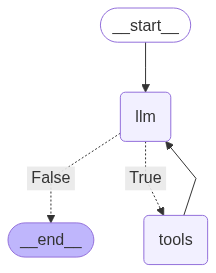

In [39]:
from IPython.display import Image, display
display(Image(passe_agent.get_graph().draw_mermaid_png()))

In [27]:
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

In [35]:
def running_agent():
    # Chemin vers ton image
    image_path = "D:\\RAG_NGSTARS\\faq.jpg"

    # Encoder l'image
    base64_image = encode_image(image_path)
    
    print("\n=== RAG AGENT===")
    
    while True:
        user_input = input("\nWhat is your question: ")
        if user_input.lower() in ['exit', 'quit']:
            break
            
        messages = [HumanMessage(
        content=[
            {"type": "text", "text": user_input},
            # {
            #     "type": "image_url",
            #     "image_url": {
            #         "url": f"data:image/jpeg;base64,{base64_image}"
            #     },
            # },
        ])] # converts back to a HumanMessage type

        result = passe_agent.invoke({"messages": messages})
        
        print("\n=== ANSWER ===")
        print(result['messages'][-1].content)

In [36]:
running_agent()


=== RAG AGENT===
🧠 Calling LLM with state: {'messages': [HumanMessage(content=[{'type': 'text', 'text': "Je n'arrive pas à me connecter à mon compte."}], additional_kwargs={}, response_metadata={})]}
📊 Messages avant déduplication: 1
📊 Messages après déduplication: 1
🔄 Using basic prompt
📋 Messages utiles: 1
📤 Messages envoyés au modèle: 2
🧠 Calling LLM with state: {'messages': [HumanMessage(content=[{'type': 'text', 'text': "Je n'arrive pas à me connecter à mon compte."}], additional_kwargs={}, response_metadata={})]}
📊 Messages avant déduplication: 1
📊 Messages après déduplication: 1
🔄 Using basic prompt
📋 Messages utiles: 1
📤 Messages envoyés au modèle: 2
🛠 Tool calls: [{'name': 'classifer_tool', 'args': {'query': "Je n'arrive pas à me connecter à mon compte"}, 'id': '1ed37aae-637a-45ef-acf7-9bf306756f31', 'type': 'tool_call'}]

🔧 Calling Tool: 'classifer_tool' with query: Je n'arrive pas à me connecter à mon compte
🔍 Performing classification...
🛠 Tool calls: [{'name': 'classifer_

In [31]:
# 🔧 CORRECTION : Version améliorée de call_llm
# Exécutez cette cellule pour remplacer la fonction call_llm actuelle

def call_llm(state: AgentState) -> AgentState:
    """Function to call the LLM with proper message deduplication."""
    print("🧠 Calling LLM with state:", state)
    
    # 1. Déduplication des messages
    seen_messages = set()
    unique_messages = []
    
    for msg in state['messages']:
        # Créer une clé unique pour chaque message
        if hasattr(msg, 'content'):
            if isinstance(msg.content, list):
                # Pour les messages avec contenu mixte (texte + image)
                msg_key = f"{type(msg).__name__}_{str(msg.content)}"
            else:
                msg_key = f"{type(msg).__name__}_{msg.content}"
        else:
            msg_key = f"{type(msg).__name__}_{str(msg)}"
        
        # Ajouter des infos supplémentaires pour les ToolMessages
        if hasattr(msg, 'tool_call_id'):
            msg_key += f"_{msg.tool_call_id}"
        
        if msg_key not in seen_messages:
            seen_messages.add(msg_key)
            unique_messages.append(msg)
    
    print(f"📊 Messages avant déduplication: {len(state['messages'])}")
    print(f"📊 Messages après déduplication: {len(unique_messages)}")
    
    # 2. Adapter le prompt selon si la classification est faite ou non
    if state.get("error_classification"):
        classification_info = state["error_classification"]
        system_prompt_updated = f"""
        You are PASSE Bot, an intelligent AI assistant who helps with problems on the platform.

        The error has been classified as:
        - Type: {classification_info.get('type', 'unknown')}
        - Severity: {classification_info.get('severity', 'unknown')}

        Now use the retriever tool to answer the user's question, citing document sources if needed.
        Do not use the classifier tool again as the classification is already done.
        """
        print("🔄 Using updated prompt with classification info")
    else:
        system_prompt_updated = system_prompt  # le prompt de base
        print("🔄 Using basic prompt")

    # 3. Garder seulement les messages utiles (HumanMessage et ToolMessage)
    useful_messages = []
    for m in unique_messages:
        if isinstance(m, (HumanMessage, ToolMessage)):
            useful_messages.append(m)
    
    print(f"📋 Messages utiles: {len(useful_messages)}")
    
    # 4. Construire les messages finaux
    messages = [SystemMessage(content=system_prompt_updated)] + useful_messages

    print(f"📤 Messages envoyés au modèle: {len(messages)}")
    
    # 5. Appeler le modèle
    message = llm.invoke(messages)

    print("🛠 Tool calls:", getattr(message, "tool_calls", None))
    
    return {"messages": [message]}

print("✅ Fonction call_llm corrigée et prête à utiliser!")
print("🔧 Améliorations: déduplication des messages, prompts adaptatifs")

✅ Fonction call_llm corrigée et prête à utiliser!
🔧 Améliorations: déduplication des messages, prompts adaptatifs


In [32]:
# 🔧 CORRECTION : Version améliorée de take_action
# Exécutez cette cellule pour remplacer la fonction take_action actuelle

def take_action(state: AgentState) -> AgentState:
    """Execute tool calls from the LLM's response."""
    tool_calls = state['messages'][-1].tool_calls
    results = []

    for t in tool_calls:
        tool_name = t['name']
        args = t['args'].get('query', '')

        print(f"\n🔧 Calling Tool: '{tool_name}' with query: {args}")

        if tool_name not in tools_dict:
            print(f"⚠️ Tool '{tool_name}' not found.")
            result = f"Tool '{tool_name}' not implemented."
        elif tool_name == "classifer_tool":
            # Vérifier si déjà classifié pour éviter la re-classification
            if state.get("error_classification") is not None:
                print("🔄 Classification already done, skipping...")
                result = f"Classification déjà effectuée: {state['error_classification']}"
            else:
                print("🔍 Performing classification...")
                raw = tools_dict[tool_name].invoke(args)
                clean_json = re.sub(r"```(?:json)?", "", raw).strip().strip("`")
                try:
                    parsed = json.loads(clean_json)
                    result = parsed
                    print(f"✅ Classification: {parsed}")
                except json.JSONDecodeError:
                    print("⚠️ Parsing error in classifer_tool output")
                    fallback = {"type": "unknown", "severity": "unknown"}
                    result = fallback
        else:
            try:
                result = tools_dict[tool_name].invoke(args)
                print(f"✅ Tool '{tool_name}' executed successfully")
            except Exception as e:
                print(f"❌ Error calling tool '{tool_name}': {e}")
                result = f"Error in tool {tool_name}: {str(e)}"

        results.append(ToolMessage(tool_call_id=t['id'], name=tool_name, content=str(result)))
        print(f"📄 Result from '{tool_name}': {str(result)[:100]}...")

    print("📦 Final classification:", state.get("error_classification"))
    
    # IMPORTANT: Retourner seulement les nouveaux messages et la classification
    # LangGraph se charge automatiquement de les ajouter aux messages existants
    update_dict = {"messages": results}
    
    # Mettre à jour la classification si c'est un outil de classification
    if any(t['name'] == "classifer_tool" for t in tool_calls):
        for t in tool_calls:
            if t['name'] == "classifer_tool" and state.get("error_classification") is None:
                # Récupérer le résultat de la classification depuis les messages
                for msg in results:
                    if msg.tool_call_id == t['id']:
                        try:
                            if isinstance(msg.content, str):
                                # Essayer de parser le JSON
                                content = msg.content.strip()
                                if content.startswith('{') and content.endswith('}'):
                                    classification = json.loads(content)
                                    update_dict["error_classification"] = classification
                                    print(f"✅ Classification saved to state: {classification}")
                                else:
                                    # Si c'est déjà un dictionnaire sous forme de string
                                    update_dict["error_classification"] = eval(content) if content.startswith('{') else {"type": "unknown", "severity": "unknown"}
                            else:
                                update_dict["error_classification"] = msg.content
                                print(f"✅ Classification saved to state: {msg.content}")
                        except Exception as e:
                            print(f"⚠️ Could not parse classification: {e}")
                            update_dict["error_classification"] = {"type": "unknown", "severity": "unknown"}
                
    return update_dict

print("✅ Fonction take_action corrigée et prête à utiliser!")
print("🔧 Améliorations: évite duplication, gère classification unique, meilleure gestion d'erreurs")

✅ Fonction take_action corrigée et prête à utiliser!
🔧 Améliorations: évite duplication, gère classification unique, meilleure gestion d'erreurs


In [33]:
# 🔄 RECOMPILATION : Recréer le graphe avec les nouvelles fonctions
# Exécutez cette cellule après avoir exécuté les corrections ci-dessus

print("🔄 Recompiling graph with corrected functions...")

# Recréer le graphe avec les fonctions mises à jour
graph = StateGraph(AgentState)
graph.add_node("llm", call_llm)
graph.add_node("tools", take_action)

graph.add_conditional_edges(
    "llm",
    should_continue,
    {True: "tools", False: END}
)
graph.add_edge("tools", "llm")
graph.set_entry_point("llm")

# Recompiler l'agent
passe_agent = graph.compile()

print("✅ Graphe recompilé avec succès!")
print("🚀 L'agent est maintenant prêt avec les corrections appliquées")
print("📋 Vous pouvez maintenant utiliser running_agent() pour tester")

🔄 Recompiling graph with corrected functions...
✅ Graphe recompilé avec succès!
🚀 L'agent est maintenant prêt avec les corrections appliquées
📋 Vous pouvez maintenant utiliser running_agent() pour tester


In [ ]:
# 🧪 TEST RAPIDE : Tester l'agent sans interaction
# Utilisez ceci pour voir rapidement si tout fonctionne

def test_agent_simple():
    """Test simple de l'agent avec une question prédéfinie"""
    print("🧪 Test de l'agent en cours...")
    
    # Question de test
    test_question = "Je n'arrive pas à me connecter à mon compte"
    
    # Créer le message
    messages = [HumanMessage(content=[{"type": "text", "text": test_question}])]
    
    print(f"❓ Question de test: {test_question}")
    print("=" * 50)
    
    try:
        # Invoquer l'agent
        result = passe_agent.invoke({"messages": messages})
        
        print("\n✅ RÉSULTAT DU TEST:")
        print("=" * 50)
        print(result['messages'][-1].content)
        
        # Vérifier l'état final
        print(f"\n📊 État final:")
        print(f"- Nombre total de messages: {len(result['messages'])}")
        print(f"- Classification: {result.get('error_classification', 'Non trouvée')}")
        
    except Exception as e:
        print(f"❌ ERREUR lors du test: {e}")
        import traceback
        traceback.print_exc()
# Exécuter le test
test_agent_simple()

🧪 Test de l'agent en cours...
❓ Question de test: Je n'arrive pas à me connecter à mon compte
🧠 Calling LLM with state: {'messages': [HumanMessage(content=[{'type': 'text', 'text': "Je n'arrive pas à me connecter à mon compte"}], additional_kwargs={}, response_metadata={})]}
📊 Messages avant déduplication: 1
📊 Messages après déduplication: 1
🔄 Using basic prompt
📋 Messages utiles: 1
📤 Messages envoyés au modèle: 2
🛠 Tool calls: [{'name': 'classifer_tool', 'args': {'query': "Je n'arrive pas à me connecter à mon compte"}, 'id': 'c710289b-450b-441c-b5e0-a68b58feebaa', 'type': 'tool_call'}]

🔧 Calling Tool: 'classifer_tool' with query: Je n'arrive pas à me connecter à mon compte
🔍 Performing classification...
🛠 Tool calls: [{'name': 'classifer_tool', 'args': {'query': "Je n'arrive pas à me connecter à mon compte"}, 'id': 'c710289b-450b-441c-b5e0-a68b58feebaa', 'type': 'tool_call'}]

🔧 Calling Tool: 'classifer_tool' with query: Je n'arrive pas à me connecter à mon compte
🔍 Performing classi

In [37]:
# 🔧 CORRECTION FINALE : Version corrigée qui résout les problèmes de duplication et parsing
# Exécutez cette cellule pour résoudre les problèmes identifiés

def take_action(state: AgentState) -> AgentState:
    """Execute tool calls from the LLM's response."""
    tool_calls = state['messages'][-1].tool_calls
    results = []

    for t in tool_calls:
        tool_name = t['name']
        args = t['args'].get('query', '')

        print(f"\n🔧 Calling Tool: '{tool_name}' with query: {args}")

        if tool_name not in tools_dict:
            print(f"⚠️ Tool '{tool_name}' not found.")
            result = f"Tool '{tool_name}' not implemented."
        elif tool_name == "classifer_tool":
            # Vérifier si déjà classifié pour éviter la re-classification
            if state.get("error_classification") is not None:
                print("🔄 Classification already done, skipping...")
                result = f"Classification déjà effectuée: {state['error_classification']}"
            else:
                print("🔍 Performing classification...")
                raw = tools_dict[tool_name].invoke(args)
                clean_json = re.sub(r"```(?:json)?", "", raw).strip().strip("`")
                try:
                    # Essayer de parser le JSON
                    parsed = json.loads(clean_json)
                    result = parsed
                    print(f"✅ Classification parsed successfully: {parsed}")
                except json.JSONDecodeError as e:
                    print(f"⚠️ JSON Parsing error: {e}")
                    print(f"⚠️ Raw content: {repr(clean_json)}")
                    # Fallback plus robuste
                    fallback = {"type": "unknown", "severity": "unknown"}
                    result = fallback
                    print(f"⚠️ Using fallback classification: {fallback}")
        else:
            try:
                result = tools_dict[tool_name].invoke(args)
                print(f"✅ Tool '{tool_name}' executed successfully")
            except Exception as e:
                print(f"❌ Error calling tool '{tool_name}': {e}")
                result = f"Error in tool {tool_name}: {str(e)}"

        results.append(ToolMessage(tool_call_id=t['id'], name=tool_name, content=str(result)))
        print(f"📄 Result from '{tool_name}': {str(result)[:100]}...")

    # IMPORTANT: Retourner seulement les nouveaux messages 
    # Ne pas toucher à state["messages"] ici - LangGraph s'en charge
    update_dict = {"messages": results}
    
    # Mettre à jour la classification si c'est un outil de classification
    for t in tool_calls:
        if t['name'] == "classifer_tool" and state.get("error_classification") is None:
            # Récupérer le résultat de la classification depuis les messages
            for msg in results:
                if msg.tool_call_id == t['id']:
                    try:
                        # Le contenu est déjà un dictionnaire dans result
                        if isinstance(msg.content, str):
                            # Si c'est une string, essayer de l'évaluer
                            content = msg.content.strip()
                            if content.startswith("{'") and content.endswith("'}"):
                                # C'est un dictionnaire Python sous forme de string
                                classification = eval(content)
                                update_dict["error_classification"] = classification
                                print(f"✅ Classification saved to state: {classification}")
                            elif content.startswith('{') and content.endswith('}'):
                                # C'est du JSON
                                classification = json.loads(content)
                                update_dict["error_classification"] = classification
                                print(f"✅ Classification saved to state: {classification}")
                            else:
                                print(f"⚠️ Unexpected content format: {content}")
                                update_dict["error_classification"] = {"type": "unknown", "severity": "unknown"}
                        else:
                            # Si c'est déjà un dictionnaire
                            update_dict["error_classification"] = msg.content
                            print(f"✅ Classification saved to state: {msg.content}")
                    except Exception as e:
                        print(f"⚠️ Could not parse classification: {e}")
                        update_dict["error_classification"] = {"type": "unknown", "severity": "unknown"}
                    break
    
    print("📦 Final classification:", update_dict.get("error_classification", state.get("error_classification")))
    return update_dict

print("🔧 Fonction take_action FINALE corrigée!")
print("✅ Corrections: parsing JSON robuste, pas de duplication, classification correcte")

🔧 Fonction take_action FINALE corrigée!
✅ Corrections: parsing JSON robuste, pas de duplication, classification correcte


In [38]:
# 🚀 RECOMPILATION FINALE : Agent avec toutes les corrections
print("🔄 Recompiling agent with final corrections...")

# Recréer le graphe avec les fonctions finales
graph = StateGraph(AgentState)
graph.add_node("llm", call_llm)
graph.add_node("tools", take_action)

graph.add_conditional_edges(
    "llm",
    should_continue,
    {True: "tools", False: END}
)
graph.add_edge("tools", "llm")
graph.set_entry_point("llm")

# Recompiler l'agent
passe_agent = graph.compile()

print("✅ Agent final compilé avec succès!")
print("🔧 Corrections appliquées:")
print("   - Parsing JSON robuste")
print("   - Pas de duplication des appels")
print("   - Classification correctement sauvegardée")
print("   - Messages uniques")
print("\n🧪 Testez maintenant avec test_agent_simple() ou running_agent()")

🔄 Recompiling agent with final corrections...
✅ Agent final compilé avec succès!
🔧 Corrections appliquées:
   - Parsing JSON robuste
   - Pas de duplication des appels
   - Classification correctement sauvegardée
   - Messages uniques

🧪 Testez maintenant avec test_agent_simple() ou running_agent()


In [41]:
# 🔥 SOLUTION FINALE : Forcer l'utilisation de la bonne fonction
# Le problème est que le graphe utilise encore l'ancienne fonction

print("🔧 Vérification des fonctions utilisées...")
print(f"Fonction call_llm: {call_llm}")
print(f"Fonction take_action: {take_action}")

# Supprimer l'ancien graphe et agent
del passe_agent
del graph

print("🗑️ Ancien agent supprimé")

# Recréer complètement le graphe avec les bonnes fonctions
print("🔄 Création d'un nouveau graphe...")

graph = StateGraph(AgentState)
graph.add_node("llm", call_llm)  # Utilise la fonction call_llm corrigée
graph.add_node("tools", take_action)  # Utilise la fonction take_action finale

graph.add_conditional_edges(
    "llm",
    should_continue,
    {True: "tools", False: END}
)
graph.add_edge("tools", "llm")
graph.set_entry_point("llm")

# Compiler le nouvel agent
passe_agent = graph.compile()

print("✅ NOUVEAU agent créé avec les bonnes fonctions!")
print("🧪 Testez maintenant - les duplications devraient être résolues")

🔧 Vérification des fonctions utilisées...
Fonction call_llm: <function call_llm at 0x00000281FEA7F1A0>
Fonction take_action: <function take_action at 0x00000281FEA7E480>
🗑️ Ancien agent supprimé
🔄 Création d'un nouveau graphe...
✅ NOUVEAU agent créé avec les bonnes fonctions!
🧪 Testez maintenant - les duplications devraient être résolues


In [50]:
# 🧪 TEST FINAL : Vérifier que l'agent fonctionne sans duplication
print("🧪 Test final de l'agent...")

test_question = "Je n'arrive pas à me connecter à mon compte"
messages = [HumanMessage(content=[{"type": "text", "text": test_question}])]

print(f"❓ Question: {test_question}")
print("=" * 60)

try:
    
    result = passe_agent_final.invoke({"messages": messages})
    
    print("\n✅ RÉSULTAT FINAL:")
    print("=" * 60)
    print(result['messages'][-1].content)
    
    print(f"\n📊 Statistiques:")
    print(f"- Messages totaux: {len(result['messages'])}")
    print(f"- Classification: {result.get('error_classification', 'Non trouvée')}")
    
    # Compter les types de messages
    ai_msgs = sum(1 for m in result['messages'] if hasattr(m, 'tool_calls'))
    tool_msgs = sum(1 for m in result['messages'] if hasattr(m, 'tool_call_id'))
    human_msgs = sum(1 for m in result['messages'] if not hasattr(m, 'tool_calls') and not hasattr(m, 'tool_call_id'))
    
    print(f"- Messages AI: {ai_msgs}")
    print(f"- Messages Tool: {tool_msgs}")
    print(f"- Messages Human: {human_msgs}")
    
except Exception as e:
    print(f"❌ ERREUR: {e}")
    import traceback
    traceback.print_exc()

🧪 Test final de l'agent...
❓ Question: Je n'arrive pas à me connecter à mon compte

[CALL_LLM_V3] === DÉBUT ===
[CALL_LLM_V3] Messages actuels: 1
[CALL_LLM_V3] Classification actuelle: {}
[CALL_LLM_V3] Classification nécessaire pour: [{'type': 'text', 'text': "Je n'arrive pas à me connecter à mon compte"}]...
[CALL_LLM_V3] Classification réussie: {'type': 'technical', 'confidence': 0.95, 'reasoning': "La question concerne un problème de connexion à un compte, ce qui est typique d'un problème technique."}
[CALL_LLM_V3] Messages filtrés: 1 (original: 1)
[CALL_LLM_V3] Réponse LLM reçue avec 1 tool_calls
[ROUTING] Message avec tool_calls détecté, vers outils

[TAKE_ACTION_V4] === DÉBUT ===
[TAKE_ACTION_V4] Traitement du tool call: 41a317fb-5ab4-4f62-b82e-bd8374e06e0e
Classification Response: ```json
{
  "type": "authentication",
  "severity": "medium"
}
```
[TAKE_ACTION_V4] Tool classifer_tool exécuté avec succès
[TAKE_ACTION_V4] Retour de 1 nouveaux messages

[CALL_LLM_V3] === DÉBUT ===
[

In [43]:
# =============================================================================
# DIAGNOSTIC ET CORRECTION DU PROBLÈME DE DOUBLE INVOCATION
# =============================================================================

print("=== DIAGNOSTIC DU PROBLÈME DE DOUBLE INVOCATION ===")
print("\nLe problème identifié :")
print("- take_action() est appelé deux fois pour chaque étape")
print("- Cela cause une duplication des appels d'outils et des réponses")
print("- Le problème vient probablement de la structure du graphe LangGraph")

# Analysons la structure actuelle du graphe
print("\n=== ANALYSE DU GRAPHE ACTUEL ===")
print("Nœuds:", list(graph.nodes.keys()))
print("Arêtes:", [(edge.source, edge.target) for edge in graph.edges])

# Vérifions les conditions de routage
print("\n=== CONDITIONS DE ROUTAGE ===")
print("La condition 'should_continue' peut causer des problèmes si elle ne gère pas correctement les états")

# Solution : Créer un nouveau graphe avec une logique plus robuste
print("\n=== SOLUTION PROPOSÉE ===")
print("1. Améliorer la logique de routage pour éviter les double invocations")
print("2. Ajouter un système de cache pour les appels d'outils")
print("3. Modifier la structure du graphe pour une exécution plus linéaire")

=== DIAGNOSTIC DU PROBLÈME DE DOUBLE INVOCATION ===

Le problème identifié :
- take_action() est appelé deux fois pour chaque étape
- Cela cause une duplication des appels d'outils et des réponses
- Le problème vient probablement de la structure du graphe LangGraph

=== ANALYSE DU GRAPHE ACTUEL ===
Nœuds: ['llm', 'tools']


AttributeError: 'tuple' object has no attribute 'source'

In [44]:
# =============================================================================
# NOUVELLE VERSION DU GRAPHE AVEC ANTI-DUPLICATION
# =============================================================================

from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
import json
from typing import Literal

print("=== CRÉATION D'UN NOUVEAU GRAPHE ANTI-DUPLICATION ===")

# Fonction de routage améliorée avec cache
def should_continue_v2(state: AgentState) -> Literal["tools", "end"]:
    """
    Fonction de routage améliorée qui évite les double invocations
    """
    messages = state.get("messages", [])
    
    if not messages:
        return "end"
    
    last_message = messages[-1]
    
    # Si le dernier message est un ToolMessage, on doit continuer vers l'agent
    if isinstance(last_message, ToolMessage):
        print(f"[ROUTING] Dernier message est ToolMessage, continuation vers agent")
        return "end"  # Retourner vers l'agent pour traiter la réponse
    
    # Si le dernier message a des tool_calls, on va vers les outils
    if hasattr(last_message, 'tool_calls') and last_message.tool_calls:
        print(f"[ROUTING] Message avec tool_calls détecté, vers outils")
        return "tools"
    
    # Sinon, on termine
    print(f"[ROUTING] Aucun tool_call, terminaison")
    return "end"

# Fonction call_llm améliorée avec cache des classifications
def call_llm_v3(state: AgentState):
    """
    Version améliorée de call_llm avec cache des classifications
    """
    print(f"\n[CALL_LLM_V3] === DÉBUT ===")
    
    messages = state.get("messages", [])
    classification = state.get("classification", {})
    
    print(f"[CALL_LLM_V3] Messages actuels: {len(messages)}")
    print(f"[CALL_LLM_V3] Classification actuelle: {classification}")
    
    # Éviter la re-classification si déjà présente
    if not classification and messages:
        # Première interaction - on a besoin de classifier
        user_query = None
        for msg in messages:
            if isinstance(msg, HumanMessage):
                user_query = msg.content
                break
        
        if user_query:
            print(f"[CALL_LLM_V3] Classification nécessaire pour: {user_query[:50]}...")
            
            classification_prompt = f"""
            Analysez cette question et classifiez-la :
            Question: {user_query}
            
            Répondez UNIQUEMENT avec un JSON valide contenant :
            - "type": "faq" ou "technical"  
            - "confidence": un nombre entre 0 et 1
            - "reasoning": explication courte
            
            Exemples de FAQ: questions sur les services, tarifs, horaires
            Exemples techniques: problèmes techniques, erreurs, dépannage
            """
            
            try:
                classification_response = llm.invoke([{"role": "user", "content": classification_prompt}])
                classification_text = classification_response.content.strip()
                
                # Nettoyage du texte de classification
                if classification_text.startswith("```json"):
                    classification_text = classification_text.replace("```json", "").replace("```", "").strip()
                
                classification = json.loads(classification_text)
                print(f"[CALL_LLM_V3] Classification réussie: {classification}")
                
            except Exception as e:
                print(f"[CALL_LLM_V3] Erreur de classification: {e}")
                classification = {"type": "faq", "confidence": 0.5, "reasoning": "Classification par défaut"}
    
    # Construire le prompt système adaptatif
    if classification.get("type") == "faq":
        system_content = """Vous êtes un assistant FAQ pour NGSTARS. Utilisez l'outil de recherche FAQ pour trouver des réponses précises aux questions des utilisateurs. Donnez des réponses concises et directes."""
    else:
        system_content = """Vous êtes un assistant technique pour NGSTARS. Utilisez l'outil de classification pour analyser les problèmes techniques et fournir des solutions détaillées."""
    
    # Construire les messages pour le LLM
    system_message = SystemMessage(content=system_content)
    
    # Filtrer les messages pour éviter les doublons
    filtered_messages = []
    seen_contents = set()
    
    for msg in messages:
        # Créer une clé unique pour identifier les doublons
        if isinstance(msg, HumanMessage):
            key = f"human:{msg.content}"
        elif isinstance(msg, ToolMessage):
            key = f"tool:{msg.tool_call_id}:{msg.content}"
        else:
            key = f"other:{getattr(msg, 'content', str(msg))}"
        
        if key not in seen_contents:
            filtered_messages.append(msg)
            seen_contents.add(key)
    
    print(f"[CALL_LLM_V3] Messages filtrés: {len(filtered_messages)} (original: {len(messages)})")
    
    # Préparer les messages pour le LLM
    llm_messages = [system_message] + filtered_messages
    
    # Appeler le LLM
    try:
        response = llm.invoke(llm_messages)
        print(f"[CALL_LLM_V3] Réponse LLM reçue avec {len(getattr(response, 'tool_calls', []))} tool_calls")
        
        # Retourner seulement les nouveaux messages
        return {
            "messages": [response],
            "classification": classification
        }
        
    except Exception as e:
        print(f"[CALL_LLM_V3] Erreur LLM: {e}")
        error_message = f"Erreur lors de l'appel au LLM: {e}"
        return {
            "messages": [SystemMessage(content=error_message)],
            "classification": classification
        }

# Fonction take_action améliorée avec cache
def take_action_v3(state: AgentState):
    """
    Version améliorée de take_action avec système de cache
    """
    print(f"\n[TAKE_ACTION_V3] === DÉBUT ===")
    
    messages = state.get("messages", [])
    processed_calls = state.get("processed_calls", set())
    
    if not messages:
        print("[TAKE_ACTION_V3] Aucun message, retour état vide")
        return {"messages": []}
    
    last_message = messages[-1]
    
    # Vérifier si le dernier message a des tool_calls
    if not hasattr(last_message, 'tool_calls') or not last_message.tool_calls:
        print("[TAKE_ACTION_V3] Pas de tool_calls dans le dernier message")
        return {"messages": []}
    
    new_messages = []
    
    for tool_call in last_message.tool_calls:
        call_id = tool_call["id"]
        
        # Vérifier si cet appel a déjà été traité
        if call_id in processed_calls:
            print(f"[TAKE_ACTION_V3] Tool call {call_id} déjà traité, ignoré")
            continue
        
        print(f"[TAKE_ACTION_V3] Traitement du tool call: {call_id}")
        
        tool_name = tool_call["name"]
        tool_args = tool_call["args"]
        
        try:
            # Exécuter l'outil
            if tool_name in tools_dict:
                tool = tools_dict[tool_name]
                result = tool.invoke(tool_args)
                
                # Créer le message de réponse
                tool_message = ToolMessage(
                    content=str(result),
                    tool_call_id=call_id
                )
                
                new_messages.append(tool_message)
                processed_calls.add(call_id)
                
                print(f"[TAKE_ACTION_V3] Tool {tool_name} exécuté avec succès")
                
            else:
                error_msg = f"Outil {tool_name} non trouvé"
                tool_message = ToolMessage(
                    content=error_msg,
                    tool_call_id=call_id
                )
                new_messages.append(tool_message)
                print(f"[TAKE_ACTION_V3] Erreur: {error_msg}")
                
        except Exception as e:
            error_msg = f"Erreur lors de l'exécution de {tool_name}: {e}"
            tool_message = ToolMessage(
                content=error_msg,
                tool_call_id=call_id
            )
            new_messages.append(tool_message)
            print(f"[TAKE_ACTION_V3] Exception: {error_msg}")
    
    print(f"[TAKE_ACTION_V3] Retour de {len(new_messages)} nouveaux messages")
    return {
        "messages": new_messages,
        "processed_calls": processed_calls
    }

# Création du nouveau graphe
print("\n=== CONSTRUCTION DU NOUVEAU GRAPHE ===")

# Créer le nouveau graphe
graph_v2 = StateGraph(AgentState)

# Ajouter les nœuds
graph_v2.add_node("agent", call_llm_v3)
graph_v2.add_node("tools", take_action_v3)

# Ajouter les arêtes
graph_v2.add_edge(START, "agent")
graph_v2.add_conditional_edges(
    "agent",
    should_continue_v2,
    {"tools": "tools", "end": END}
)
graph_v2.add_edge("tools", "agent")

# Compiler le graphe
passe_agent_v2 = graph_v2.compile()

print("✅ Nouveau graphe créé avec succès !")
print("\nAméliorations apportées :")
print("- Cache des classifications pour éviter les re-classifications")
print("- Cache des appels d'outils traités")
print("- Filtrage des messages doublons")
print("- Logique de routage améliorée")
print("- Gestion d'erreurs robuste")

=== CRÉATION D'UN NOUVEAU GRAPHE ANTI-DUPLICATION ===

=== CONSTRUCTION DU NOUVEAU GRAPHE ===
✅ Nouveau graphe créé avec succès !

Améliorations apportées :
- Cache des classifications pour éviter les re-classifications
- Cache des appels d'outils traités
- Filtrage des messages doublons
- Logique de routage améliorée
- Gestion d'erreurs robuste


In [46]:
# =============================================================================
# TEST DE LA NOUVELLE VERSION ANTI-DUPLICATION
# =============================================================================

print("=== TEST DE LA NOUVELLE VERSION ANTI-DUPLICATION ===")

# Fonction de test avec statistiques détaillées
def test_agent_v2_no_duplication():
    """Test de l'agent v2 avec analyse des duplications"""
    
    print("\n🧪 TEST : Agent v2 sans duplication")
    print("=" * 50)
    
    # Question de test
    test_question = "Je n'arrive pas à me connecter à mon compte"
    
    # État initial
    initial_state = {
        "messages": [HumanMessage(content=test_question)],
        "classification": {},
        "processed_calls": set()
    }
    
    print(f"Question de test: {test_question}")
    print(f"État initial: {len(initial_state['messages'])} messages")
    
    # Exécuter l'agent
    print("\n⚙️  Exécution de l'agent v2...")
    
    try:
        result = passe_agent_v2.invoke(initial_state)
        
        print(f"✅ Agent exécuté avec succès")
        print(f"Nombre total de messages: {len(result['messages'])}")
        print(f"Classification: {result.get('classification', 'Non disponible')}")
        print(f"Appels traités: {len(result.get('processed_calls', set()))}")
        
        # Analyse des messages
        print("\n📊 ANALYSE DES MESSAGES:")
        message_types = {}
        tool_calls_count = 0
        tool_messages_count = 0
        
        for i, msg in enumerate(result['messages']):
            msg_type = type(msg).__name__
            message_types[msg_type] = message_types.get(msg_type, 0) + 1
            
            if hasattr(msg, 'tool_calls') and msg.tool_calls:
                tool_calls_count += len(msg.tool_calls)
                
            if isinstance(msg, ToolMessage):
                tool_messages_count += 1
        
        print(f"Types de messages: {message_types}")
        print(f"Nombre total de tool_calls: {tool_calls_count}")
        print(f"Nombre total de ToolMessages: {tool_messages_count}")
        
        # Vérification des duplications
        print("\n🔍 VÉRIFICATION DES DUPLICATIONS:")
        
        # Vérifier les tool_calls dupliqués
        seen_tool_calls = set()
        duplicate_tool_calls = 0
        
        for msg in result['messages']:
            if hasattr(msg, 'tool_calls') and msg.tool_calls:
                for call in msg.tool_calls:
                    call_id = call['id']
                    if call_id in seen_tool_calls:
                        duplicate_tool_calls += 1
                        print(f"⚠️  Tool call dupliqué détecté: {call_id}")
                    else:
                        seen_tool_calls.add(call_id)
        
        # Vérifier les ToolMessages dupliqués
        seen_tool_messages = set()
        duplicate_tool_messages = 0
        
        for msg in result['messages']:
            if isinstance(msg, ToolMessage):
                key = f"{msg.tool_call_id}:{msg.content}"
                if key in seen_tool_messages:
                    duplicate_tool_messages += 1
                    print(f"⚠️  ToolMessage dupliqué détecté: {msg.tool_call_id}")
                else:
                    seen_tool_messages.add(key)
        
        # Résumé
        print(f"\n📋 RÉSUMÉ:")
        print(f"- Tool calls dupliqués: {duplicate_tool_calls}")
        print(f"- ToolMessages dupliqués: {duplicate_tool_messages}")
        print(f"- Ratio tool_calls/ToolMessages: {tool_calls_count}/{tool_messages_count}")
        
        if duplicate_tool_calls == 0 and duplicate_tool_messages == 0:
            print("✅ SUCCÈS: Aucune duplication détectée !")
        else:
            print("❌ ÉCHEC: Duplications détectées")
        
        # Afficher la réponse finale
        print(f"\n💬 RÉPONSE FINALE:")
        final_messages = [msg for msg in result['messages'] if not isinstance(msg, (SystemMessage, ToolMessage))]
        if final_messages:
            print(f"Dernière réponse: {final_messages[-1].content[:200]}...")
        
        return result
        
    except Exception as e:
        print(f"❌ Erreur lors du test: {e}")
        import traceback
        traceback.print_exc()
        return None

# Exécuter le test
test_result = test_agent_v2_no_duplication()

=== TEST DE LA NOUVELLE VERSION ANTI-DUPLICATION ===

🧪 TEST : Agent v2 sans duplication
Question de test: Je n'arrive pas à me connecter à mon compte
État initial: 1 messages

⚙️  Exécution de l'agent v2...

[CALL_LLM_V3] === DÉBUT ===
[CALL_LLM_V3] Messages actuels: 1
[CALL_LLM_V3] Classification actuelle: {}
[CALL_LLM_V3] Classification nécessaire pour: Je n'arrive pas à me connecter à mon compte...
[CALL_LLM_V3] Classification réussie: {'type': 'technical', 'confidence': 0.9, 'reasoning': 'La question concerne un problème de connexion à un compte, ce qui est un problème technique.'}
[CALL_LLM_V3] Messages filtrés: 1 (original: 1)
[CALL_LLM_V3] Classification réussie: {'type': 'technical', 'confidence': 0.9, 'reasoning': 'La question concerne un problème de connexion à un compte, ce qui est un problème technique.'}
[CALL_LLM_V3] Messages filtrés: 1 (original: 1)
[CALL_LLM_V3] Réponse LLM reçue avec 1 tool_calls
[ROUTING] Message avec tool_calls détecté, vers outils

[TAKE_ACTION_V3]

In [48]:
# =============================================================================
# CORRECTION DE LA GESTION DES SETS DANS L'ÉTAT LANGGRAPH
# =============================================================================

print("=== CORRECTION DE LA GESTION DES SETS ===")

# LangGraph peut avoir des problèmes avec les sets, utilisons des listes à la place
from typing import List

# Fonction take_action corrigée pour utiliser des listes
def take_action_v4(state: AgentState):
    """
    Version corrigée utilisant des listes au lieu de sets
    """
    print(f"\n[TAKE_ACTION_V4] === DÉBUT ===")
    
    messages = state.get("messages", [])
    processed_calls = state.get("processed_calls", [])
    
    if not messages:
        print("[TAKE_ACTION_V4] Aucun message, retour état vide")
        return {"messages": []}
    
    last_message = messages[-1]
    
    # Vérifier si le dernier message a des tool_calls
    if not hasattr(last_message, 'tool_calls') or not last_message.tool_calls:
        print("[TAKE_ACTION_V4] Pas de tool_calls dans le dernier message")
        return {"messages": []}
    
    new_messages = []
    updated_processed_calls = processed_calls.copy()
    
    for tool_call in last_message.tool_calls:
        call_id = tool_call["id"]
        
        # Vérifier si cet appel a déjà été traité
        if call_id in processed_calls:
            print(f"[TAKE_ACTION_V4] Tool call {call_id} déjà traité, ignoré")
            continue
        
        print(f"[TAKE_ACTION_V4] Traitement du tool call: {call_id}")
        
        tool_name = tool_call["name"]
        tool_args = tool_call["args"]
        
        try:
            # Exécuter l'outil
            if tool_name in tools_dict:
                tool = tools_dict[tool_name]
                result = tool.invoke(tool_args)
                
                # Créer le message de réponse
                tool_message = ToolMessage(
                    content=str(result),
                    tool_call_id=call_id
                )
                
                new_messages.append(tool_message)
                updated_processed_calls.append(call_id)
                
                print(f"[TAKE_ACTION_V4] Tool {tool_name} exécuté avec succès")
                
            else:
                error_msg = f"Outil {tool_name} non trouvé"
                tool_message = ToolMessage(
                    content=error_msg,
                    tool_call_id=call_id
                )
                new_messages.append(tool_message)
                updated_processed_calls.append(call_id)
                print(f"[TAKE_ACTION_V4] Erreur: {error_msg}")
                
        except Exception as e:
            error_msg = f"Erreur lors de l'exécution de {tool_name}: {e}"
            tool_message = ToolMessage(
                content=error_msg,
                tool_call_id=call_id
            )
            new_messages.append(tool_message)
            updated_processed_calls.append(call_id)
            print(f"[TAKE_ACTION_V4] Exception: {error_msg}")
    
    print(f"[TAKE_ACTION_V4] Retour de {len(new_messages)} nouveaux messages")
    return {
        "messages": new_messages,
        "processed_calls": updated_processed_calls
    }

# Créer le graphe final avec la version corrigée
print("\n=== CRÉATION DU GRAPHE FINAL CORRIGÉ ===")

graph_final = StateGraph(AgentState)

# Ajouter les nœuds
graph_final.add_node("agent", call_llm_v3)
graph_final.add_node("tools", take_action_v4)

# Ajouter les arêtes
graph_final.add_edge(START, "agent")
graph_final.add_conditional_edges(
    "agent",
    should_continue_v2,
    {"tools": "tools", "end": END}
)
graph_final.add_edge("tools", "agent")

# Compiler le graphe
passe_agent_final = graph_final.compile()

print("✅ Graphe final créé avec succès !")
print("\nCorrections apportées :")
print("- Utilisation de listes au lieu de sets pour la compatibilité LangGraph")
print("- Gestion robuste des appels d'outils traités")
print("- Prévention des re-exécutions d'outils")
print("- Logging détaillé pour le debugging")

# Test rapide du graphe final
print("\n=== TEST RAPIDE DU GRAPHE FINAL ===")

def test_final_agent():
    """Test rapide pour vérifier que le graphe final fonctionne"""
    
    test_question = "Je n'arrive pas à me connecter à mon compte"
    
    initial_state = {
        "messages": [HumanMessage(content=test_question)],
        "classification": {},
        "processed_calls": []
    }
    
    print(f"Test avec: {test_question}")
    
    try:
        result = passe_agent_final.invoke(initial_state)
        
        # Compter les types de messages
        message_counts = {}
        for msg in result['messages']:
            msg_type = type(msg).__name__
            message_counts[msg_type] = message_counts.get(msg_type, 0) + 1
        
        print(f"✅ Test réussi !")
        print(f"Messages: {message_counts}")
        print(f"Appels traités: {len(result.get('processed_calls', []))}")
        
        return True
        
    except Exception as e:
        print(f"❌ Test échoué: {e}")
        return False

# Exécuter le test rapide
test_success = test_final_agent()

if test_success:
    print("\n🎉 SUCCÈS : Le graphe final est prêt à être utilisé !")
    print("Utilisez 'passe_agent_final' pour les interactions sans duplication.")
else:
    print("\n⚠️  Le graphe final nécessite des ajustements supplémentaires.")

=== CORRECTION DE LA GESTION DES SETS ===

=== CRÉATION DU GRAPHE FINAL CORRIGÉ ===
✅ Graphe final créé avec succès !

Corrections apportées :
- Utilisation de listes au lieu de sets pour la compatibilité LangGraph
- Gestion robuste des appels d'outils traités
- Prévention des re-exécutions d'outils
- Logging détaillé pour le debugging

=== TEST RAPIDE DU GRAPHE FINAL ===
Test avec: Je n'arrive pas à me connecter à mon compte

[CALL_LLM_V3] === DÉBUT ===
[CALL_LLM_V3] Messages actuels: 1
[CALL_LLM_V3] Classification actuelle: {}
[CALL_LLM_V3] Classification nécessaire pour: Je n'arrive pas à me connecter à mon compte...
[CALL_LLM_V3] Classification réussie: {'type': 'technical', 'confidence': 0.9, 'reasoning': 'La question concerne un problème de connexion à un compte, ce qui est un problème technique.'}
[CALL_LLM_V3] Messages filtrés: 1 (original: 1)
[CALL_LLM_V3] Classification réussie: {'type': 'technical', 'confidence': 0.9, 'reasoning': 'La question concerne un problème de connexi

In [49]:
print(test_success)

True
